With a history going back over 100 years, the annual Ohio State/Michigan college football game is the greatest rivalry in all of sports and is simply referred to as "The Game".  Is the intensity of this rivalry reflected in game day attendance versus season average attendance for the home team each year?

Using multiple publicly available datasets covering the years 2005-2013, we will visualize attendance for The Game each year versus the mean attendance for the rest of the season.

<IPython.core.display.Javascript object>


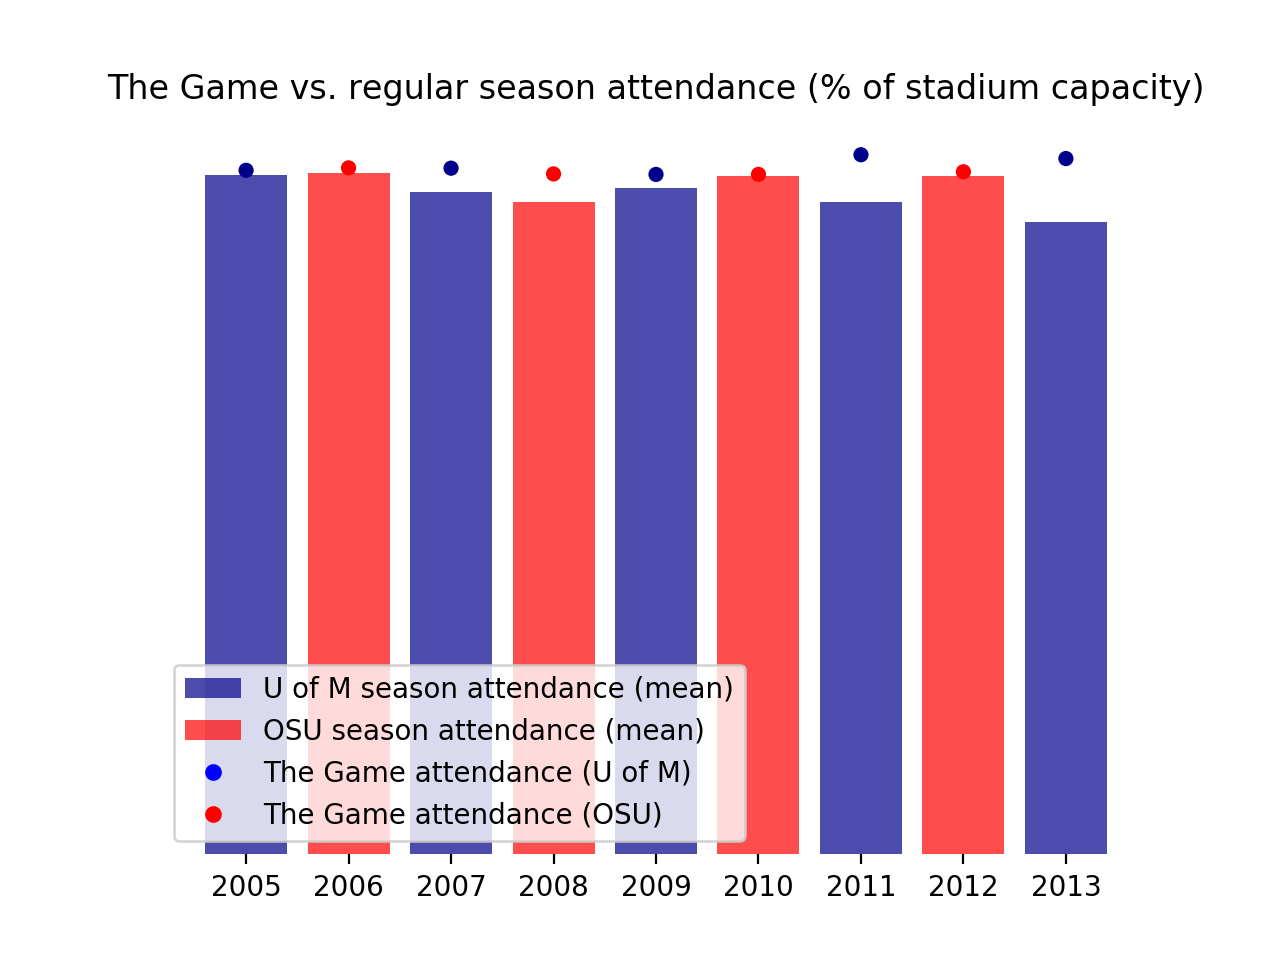

8

In [3]:
%matplotlib notebook
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax

##useful if you need to see data that default settings truncate
#pd.options.display.max_columns = 100
#pd.options.display.max_rows = 400

path = r'data/cfb_stats/cfbstats-com-*'
attend_files = glob.iglob(os.path.join(path, "game-statistics.csv"))
game_files = glob.iglob(os.path.join(path, "game.csv"))
stats_files = glob.iglob(os.path.join(path, "team-game-statistics.csv"))
snoozle_files = glob.iglob(os.path.join("data/cfb_stats/snoozleQuery*2019.csv"))

attend = pd.concat((pd.read_csv(f) for f in attend_files), ignore_index=True)
games = pd.concat((pd.read_csv(f, usecols=('Game Code', 'Date'), parse_dates=['Date']) for 
                   f in game_files), ignore_index=True)
## team IDs don't change across year, so we only need to read one file
teams = pd.read_csv('data/cfb_stats/cfbstats-com-2005-1-5-0/team.csv')
ttun = int(teams.loc[teams['Name'] == 'Michigan', 'Team Code'].values)
osu = int(teams.loc[teams['Name'] == 'Ohio State', 'Team Code'].values)

## can't get this to work for some reason, even though it's the same method as the others. have 
## to do it manually for now
#snoozle = pd.concat((pd.read_csv(f, usecols=('Date', 'Vis Team', 'Score', 'Home Team', 'Score.1'), 
 #                    na_values=-999, parse_dates=['Date'], skipinitialspace=True) for f in snoozle_files),
 #                    ignore_index=True)
snoozleOSU = pd.read_csv('data/cfb_stats/snoozleQuery Ohio State 2000-2019.csv', 
                         usecols=('Date', 'Vis Team', 'Score', 'Home Team', 'Score.1'), 
                         na_values=-999, parse_dates=['Date'], skipinitialspace=True)
snoozleMich = pd.read_csv('data/cfb_stats/snoozleQuery Michigan 2000-2019.csv', 
                          usecols=('Date', 'Vis Team', 'Score', 'Home Team', 'Score.1'), 
                          na_values=-999, parse_dates=['Date'], skipinitialspace=True)
snoozles = [snoozleOSU, snoozleMich]
snoozle = pd.concat(snoozles)

## add team ID to snoozle stats for merging since date isn't unique
snoozle = snoozle[(snoozle['Home Team'] == 'Michigan') | (snoozle['Home Team'] == 'OSU')]
snoozle.loc[snoozle['Home Team'] == 'Michigan', 'Team Code'] = ttun
snoozle.loc[snoozle['Home Team'] == 'OSU', 'Team Code'] = osu

## read in stats files for all teams and seasons, chop down to osu and that team up north
df = pd.concat((pd.read_csv(f, usecols=('Team Code', 'Game Code')) for f in stats_files), 
               ignore_index=True)
df = df[(df['Team Code'] == ttun) | (df['Team Code'] == osu)]

df = df.merge(attend, on='Game Code', how='inner')
df = df.merge(games, on='Game Code', how='inner')
df = df.merge(snoozle, on=['Date', 'Team Code'], how='inner')

df['Season'] = df['Date'].dt.year
thegame = df[df.duplicated(subset=('Game Code', 'Date'), keep='first')]
df = df[~df['Game Code'].isin(thegame['Game Code'])]

seasonAttend = df.groupby(['Season', 'Home Team']).agg({ 'Attendance': ['mean']})

thegame.loc[thegame['Home Team'] == 'Michigan', 'Color'] = 'darkblue'
thegame.loc[thegame['Home Team'] == 'OSU', 'Color'] = 'red'
thegame = thegame.merge(seasonAttend, on=['Season', 'Home Team'], how='inner')

##convert the absolute attendance numbers to %
#shoe - raised the capacity to 101,568 by 2001 and to 102,329 in 2007
#big house - official capacity is 107,601
thegame.loc[thegame['Home Team'] == 'Michigan', 'mean_pct'] = \
    (thegame.loc[thegame['Home Team'] == 'Michigan', [('Attendance', 'mean')]].values/107601)*100
thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] < 2007)), 'mean_pct'] = \
    (thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] < 2007)), 
                 [('Attendance', 'mean')]].values/101568)*100
thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] >= 2007)), 'mean_pct'] = \
    (thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] >= 2007)), 
                 [('Attendance', 'mean')]].values/102329)*100

## ditto with attendance for the game
thegame.loc[thegame['Home Team'] == 'Michigan', 'attend_pct'] = \
    (thegame.loc[thegame['Home Team'] == 'Michigan', 'Attendance'].values/107601)*100
thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] < 2007)), 'attend_pct'] = \
    (thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] < 2007)), 
                 'Attendance'].values/101568)*100
thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] >= 2007)), 'attend_pct'] = \
    (thegame.loc[((thegame['Home Team'] == 'OSU') & (thegame['Season'] >= 2007)), 
                 'Attendance'].values/102329)*100

fig, ax = plt.subplots()

## these two use absolute numbers.  title will need updated.
#bar = plt.bar(thegame['Season'], thegame[('Attendance', 'mean')], color=thegame['Color'], alpha=0.7)
#sc = plt.scatter(thegame['Season'], thegame['Attendance'], s=20, c=thegame['Color'], picker=5)

## these two use %
bar = plt.bar(thegame['Season'], thegame['mean_pct'], color=thegame['Color'], alpha=0.7)
sc = plt.scatter(thegame['Season'], thegame['attend_pct'], s=20, c=thegame['Color'], picker=5)

## need proxy artists to label the scatter points in the legend without having eight entries
proxies = [plt.Line2D([],[], marker="o", ms=5, ls="", color=c) for c in ['blue', 'red']]

plt.legend((bar.patches[0], bar.patches[1], *proxies), ('U of M season attendance (mean)', 
                                                        'OSU season attendance (mean)',
                                                        'The Game attendance (U of M)', 
                                                        'The Game attendance (OSU)'))

## remove the border of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.gca().set_title('The Game vs. regular season attendance (% of stadium capacity)')
ax.set_xticks(thegame['Season'])
ax.get_yaxis().set_ticks([])

## everything below here is under development and is only used for tooltip-style
## popups of the scatter plot
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="-|>"))
annot.set_visible(False)

def update_annot(ind, event):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    #text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
    #                       " ".join([names[n] for n in ind["ind"]]))
    #text = format('{}, {}'.format(event.xdata, event.ydata))
    #origin = thegame.iloc[event.ind[0]]['Attendance']
    #text = format('{}'.format(origin))
    text = format('{:.0f}'.format(event.ydata))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    #plt.gca().set_title('event = {}'.format(event))
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind, event)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

def on_press(event):
    pass
    #threshold = event.ydata   
    #plt.delaxes()
    #plt.axhline(threshold)
    #update(threshold)

#for i,type in enumerate(types):
#    x = x_coords[i]
#    y = y_coords[i]
#    plt.scatter(x, y, marker='x', color='red')
#    plt.text(x+0.3, y+0.3, michattend['Attendance'], fontsize=9)
#plt.show()

#plt.gcf().canvas.mpl_connect('button_press_event', on_press)

def onpick(event):
    origin = thegame.iloc[event.ind[0]]['Attendance']
    plt.gca().set_title('Selected item came from {}'.format(origin))
    #plt.gca().set_title('origin = {}'.format(event.ind))

# tell mpl_connect we want to pass a 'pick_event' into onpick when the event is detected
plt.gcf().canvas.mpl_connect('pick_event', onpick)